In [1]:
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np
from matplotlib import pyplot as plt
from keras_frcnn import data_generators 
from keras_frcnn import vgg as nn

def get_data(input_path, cat=None):
    all_imgs = []

    classes_count = {}

    class_mapping = {}

    visualise = False

    # add VOC2012 if using.
    data_paths = [os.path.join(input_path, s) for s in ['VOC2007']]
    #data_paths = [os.path.join(input_path,s) for s in ['VOC2007', 'VOC2012']]
    print("data path:", data_paths)

    print('Parsing annotation files')

    for data_path in data_paths:

        annot_path = os.path.join(data_path, 'Annotations')
        imgs_path = os.path.join(data_path, 'JPEGImages')

        # load all train images or only one category.
        #ignore all val images and treat them as train images 
        imgsets_path_trainval = os.path.join(
            data_path, 'ImageSets', 'Main', 'trainval.txt')
        imgsets_path_test = os.path.join(
            data_path, 'ImageSets', 'Main', 'test.txt')

        trainval_files = []
        test_files = []
        try:
            with open(imgsets_path_trainval) as f:
                for line in f:
                    trainval_files.append(line.strip() + '.jpg')
        except Exception as e:
            print(e)

        try:
            with open(imgsets_path_test) as f:
                for line in f:
                    test_files.append(line.strip() + '.jpg')
                   

        except Exception as e:
            if data_path[-7:] == 'VOC2012':
                # this is expected, most pascal voc distibutions dont have the test.txt file
                pass
            else:
                print(e)

        annots = [os.path.join(annot_path, s) for s in os.listdir(annot_path)]
        idx = 0
        for annot in annots:
            try:
                idx += 1

                et = ET.parse(annot)
                element = et.getroot()

                element_objs = element.findall('object')
                element_filename = element.find('filename').text
                element_width = int(element.find('size').find('width').text)
                element_height = int(element.find('size').find('height').text)

                if len(element_objs) > 0:
                    annotation_data = {'filepath': os.path.join(imgs_path, element_filename), 'width': element_width,
                                       'height': element_height, 'bboxes': []}

                    if element_filename in trainval_files: #if the image id appears in the trainval list 
                        annotation_data['imageset'] = 'trainval'
                    elif element_filename in test_files: #if the image id appears in the test list ("test.txt")
                        annotation_data['imageset'] = 'test'
                    else: #everything else goes to the trainval 
                        annotation_data['imageset'] = 'trainval'

                for element_obj in element_objs:
                    class_name = element_obj.find('name').text
                    if class_name not in classes_count:
                        classes_count[class_name] = 1
                    else:
                        classes_count[class_name] += 1

                    if class_name not in class_mapping:
                        class_mapping[class_name] = len(class_mapping)

                    obj_bbox = element_obj.find('bndbox')
                    x1 = int(round(float(obj_bbox.find('xmin').text)))
                    y1 = int(round(float(obj_bbox.find('ymin').text)))
                    x2 = int(round(float(obj_bbox.find('xmax').text)))
                    y2 = int(round(float(obj_bbox.find('ymax').text)))
                    difficulty = 1  # parse all files.
                    annotation_data['bboxes'].append(
                        {'class': class_name, 'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2, 'difficult': difficulty})

                if cat and class_name == cat:
                    all_imgs.append(annotation_data)
                elif not cat:
                    all_imgs.append(annotation_data)

                if visualise:
                    img = cv2.imread(annotation_data['filepath'])
                    for bbox in annotation_data['bboxes']:
                        cv2.rectangle(img, (bbox['x1'], bbox['y1']), (bbox[
                            'x2'], bbox['y2']), (0, 0, 255))
                    cv2.imshow('img', img)
                    cv2.waitKey(0)

            except Exception as e:
                print(e)
                continue
    return all_imgs, classes_count, class_mapping


Using TensorFlow backend.


In [2]:
train_imgs,classes_count,class_mapping=get_data(r'D:\Computer science\FASTER_RCNN_COLAB\NEW_TRAIN\VOCdevkit')

data path: ['D:\\Computer science\\FASTER_RCNN_COLAB\\NEW_TRAIN\\VOCdevkit\\VOC2007']
Parsing annotation files
[Errno 2] No such file or directory: 'D:\\Computer science\\FASTER_RCNN_COLAB\\NEW_TRAIN\\VOCdevkit\\VOC2007\\ImageSets\\Main\\test.txt'


In [3]:
train_imgs

[{'filepath': 'D:\\Computer science\\FASTER_RCNN_COLAB\\NEW_TRAIN\\VOCdevkit\\VOC2007\\JPEGImages\\000005.jpg',
  'width': 500,
  'height': 375,
  'bboxes': [{'class': 'chair',
    'x1': 263,
    'x2': 324,
    'y1': 211,
    'y2': 339,
    'difficult': 1},
   {'class': 'chair',
    'x1': 165,
    'x2': 253,
    'y1': 264,
    'y2': 372,
    'difficult': 1},
   {'class': 'chair', 'x1': 5, 'x2': 67, 'y1': 244, 'y2': 374, 'difficult': 1},
   {'class': 'chair',
    'x1': 241,
    'x2': 295,
    'y1': 194,
    'y2': 299,
    'difficult': 1},
   {'class': 'chair',
    'x1': 277,
    'x2': 312,
    'y1': 186,
    'y2': 220,
    'difficult': 1}],
  'imageset': 'trainval'},
 {'filepath': 'D:\\Computer science\\FASTER_RCNN_COLAB\\NEW_TRAIN\\VOCdevkit\\VOC2007\\JPEGImages\\000007.jpg',
  'width': 500,
  'height': 333,
  'bboxes': [{'class': 'car',
    'x1': 141,
    'x2': 500,
    'y1': 50,
    'y2': 330,
    'difficult': 1}],
  'imageset': 'trainval'},
 {'filepath': 'D:\\Computer science\\FASTE

In [4]:
classes_count

{'chair': 1432,
 'car': 1644,
 'horse': 406,
 'person': 5447,
 'bicycle': 418,
 'cat': 389,
 'dog': 538,
 'train': 328,
 'aeroplane': 331,
 'diningtable': 310,
 'tvmonitor': 367,
 'bird': 599,
 'bottle': 634,
 'motorbike': 390,
 'pottedplant': 625,
 'boat': 398,
 'sofa': 425,
 'sheep': 353,
 'cow': 356,
 'bus': 272}

In [5]:
from keras import backend as K
import math

class Config:

	def __init__(self):

		self.verbose = True

		self.network = 'resnet50'

		# setting for data augmentation
		self.use_horizontal_flips = False
		self.use_vertical_flips = False
		self.rot_90 = False
		self.noise=False
		self.blur=False
		self.brightness=False 

		#counting the number of augmentation options 
		self.list=[]

		# anchor box scales
		self.anchor_box_scales = [128, 256, 512]

		# anchor box ratios
		self.anchor_box_ratios = [[1, 1], [1, 2], [2, 1]]

		# size to resize the smallest side of the image
		self.im_size = 600

		# image channel-wise mean to subtract
		self.img_channel_mean = [103.939, 116.779, 123.68]
		self.img_scaling_factor = 1.0

		# number of ROIs at once
		self.num_rois = 300

		# stride at the RPN (this depends on the network configuration)
		self.rpn_stride = 16

		self.balanced_classes = False

		# scaling the stdev
		self.std_scaling = 4.0
		self.classifier_regr_std = [8.0, 8.0, 4.0, 4.0]

		# overlaps for RPN
		self.rpn_min_overlap = 0.3
		self.rpn_max_overlap = 0.7

		# overlaps for classifier ROIs
		self.classifier_min_overlap = 0.1
		self.classifier_max_overlap = 0.5

		# placeholder for the class mapping, automatically generated by the parser
		self.class_mapping = None

		#location of pretrained weights for the base network 
		# weight files can be found at:
		# https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_th_dim_ordering_th_kernels_notop.h5
		# https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

		self.model_path = 'model_frcnn.vgg.hdf5'


In [6]:
C = Config()
# C.list.append('original')
# C.list.append('horizontal_flips')
# C.list.append('vertical_flips')
# C.list.append('rotational')
# C.list.append('noise')
# C.list.append('blur')
C.list.append('brightness')

In [35]:
data_gen_train = data_generators.get_anchor_gt(
    train_imgs, classes_count, C, nn.get_img_output_length, K.image_dim_ordering(), mode='train')

In [45]:
X, Y, img_data,debug_img = next(data_gen_train)

brightness


In [46]:
debug_img = cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB)

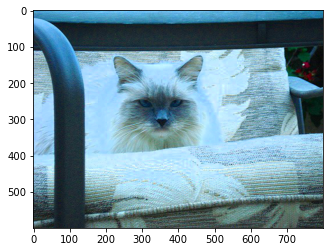

In [47]:
plt.imshow(debug_img)